In [1]:
import librosa, librosa.display
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import time

import warnings
warnings.filterwarnings("ignore")

n_fft = 1024
hop_length = 8
sr = 16000

# cate bucati PF iau in considerare pentru AF -> cu overlapping => 15 frame-uri 
# ultimul frame din AF fiind PF-ul curent
nb_of_frames_in_AF = 4
# exp_w_avg_beta = 0.98
marja_eroare = 1e-2

# frame_length_ms = 5
# total_length_ms = 5000.0
# nb_of_samples = 80000
samples_per_frame_10ms = 160 #(int)(160000 * 10 / 10000.0)
samples_per_frame_5ms = 80 #(int)(80000 * 5 / 5000.0)

In [2]:
def normaliz(mix):
    mu = np.mean(mix, axis=0)
    var = np.var(mix, axis=0)

    mix_norm = (mix - mu) / np.sqrt(var + 1e-8)
    
    return mix_norm

In [3]:
def compute_mask(stft_1, stft_2):
    # small epsilon to avoid dividing by zero
    eps = np.finfo(np.float).eps

    # compute model as the sum of spectrograms
    mix = eps + np.abs(stft_1) + np.abs(stft_2)    
    mask = np.divide(np.abs(stft_1), mix)
    
    return mask

In [4]:
def get_STFT_AF_frames(AF_array, PF_size):
    frames = []
    half = (int)(PF_size/2)
    frames_added = 0
    
    i = AF_array.shape[0]-1
    
    # use AF as 4 times bigger than PF's size -> PF = 10 ms => AF = 40 ms
    
    #---------------------------------------------------------------------------
    # 1. add PF[i]
    frame = librosa.stft(librosa.to_mono(AF_array[i]), window='hann', n_fft=n_fft, hop_length=hop_length)
    frame = np.abs(frame)
    frame = normaliz(frame)
    
    tensor = []
    tensor.append(frame)        
    frames.append(tensor)
    
    #---------------------------------------------------------------------------
    # 2. add PF[i-1, i] -> overlap
    overlap_frame = AF_array[i-1][half:]
    overlap_frame = np.concatenate((overlap_frame, AF_array[i][:half]))
    
    frame = librosa.stft(librosa.to_mono(overlap_frame), window='hann', n_fft=n_fft, hop_length=hop_length)
    frame = np.abs(frame)
    frame = normaliz(frame)

    tensor = []
    tensor.append(frame)
    frames.append(tensor)
    
    #---------------------------------------------------------------------------
    # 3. add PF[i - 1]
    frame = librosa.stft(librosa.to_mono(AF_array[i - 1]), window='hann', n_fft=n_fft, hop_length=hop_length)
    frame = np.abs(frame)
    frame = normaliz(frame)
    
    tensor = []
    tensor.append(frame)        
    frames.append(tensor)
    
    #---------------------------------------------------------------------------
    # 4. add PF[i-1, i] -> overlap
    overlap_frame = AF_array[i-1][half:]
    overlap_frame = np.concatenate((overlap_frame, AF_array[i][:half]))
    
    frame = librosa.stft(librosa.to_mono(overlap_frame), window='hann', n_fft=n_fft, hop_length=hop_length)
    frame = np.abs(frame)
    frame = normaliz(frame)

    tensor = []
    tensor.append(frame)
    frames.append(tensor)
        
    
    return np.asarray(frames)

In [5]:
def get_train_set_for_mix(mix, voice_1, voice_2, samples_per_frame):
    inputs = []
    targets = []
    
    mix_frames = np.array([mix[i:i + samples_per_frame] for i in range(0, len(mix), samples_per_frame)])
    voice_1_frames = np.array([voice_1[i:i + samples_per_frame] for i in range(0, len(mix), samples_per_frame)])
    voice_2_frames = np.array([voice_2[i:i + samples_per_frame] for i in range(0, len(mix), samples_per_frame)])
    
    for index in range(mix_frames.shape[0]):
        
        if index < 2:
            continue
        
        # 1. create train set input for AF with current PF and previous frames
        AF_frames = np.array([mix_frames[i] for i in range(index - 2, index)])      
        AF_STFT_frames = get_STFT_AF_frames(AF_array=AF_frames, PF_size= samples_per_frame)
        inputs.append(AF_STFT_frames)
        
        # 2. create train set target for that AF, containing the mask for the current PF
        stft_voice_1 = librosa.stft(librosa.to_mono(voice_1_frames[index]), window='hann', n_fft=n_fft, hop_length=hop_length)
        stft_voice_2 = librosa.stft(librosa.to_mono(voice_2_frames[index]), window='hann', n_fft=n_fft, hop_length=hop_length)
        mask = compute_mask(stft_voice_1, stft_voice_2)
        
        targets.append(mask)
    
    # train set for only one audio
    train_set_input = torch.from_numpy(np.array(inputs))
    
    # target contains the calculated masks for each PF from mix
    train_set_target = torch.from_numpy(np.array(targets))
    return np.array(inputs), np.array(targets)
    

In [6]:
class Network(nn.Module):
    height = 0
    width = 0
    
    # default values for height and width are given for a processing frame of 10 ms
    # 5 ms  = [513, 11]
    def __init__(self, height = 513, width = 21):
        super(Network, self).__init__()
        self.height = height
        self.width = width
        
        # layer 1
        self.fc1 = nn.Linear(1 * height * width, 250)
        self.fc1_batch = nn.BatchNorm1d(250)
        
        # layer 2
        self.fc2 = nn.Linear(250, 250)
        self.fc2_batch = nn.BatchNorm1d(250)
        
        # layer 3
        self.fc3 = nn.Linear(250, height * width)
        self.fc3_batch = nn.BatchNorm1d(height * width)

    def forward(self, x):
        
        # layer 1
        # firstly, transform the matrix into an array for the FC
        x = x.view(-1, self.height * self.width)        
        x = self.fc1(x)
        x = self.fc1_batch(x)
        x = torch.relu(x)
        
        # layer 2
        x = self.fc2(x)
        x = self.fc2_batch(x)
        x = torch.relu(x)
        
        # layer 3
        x = self.fc3(x)
        x = self.fc3_batch(x)
        x = torch.relu(x)
        
        x = x.view(nb_of_frames_in_AF, self.height, self.width) 
        
        return x

In [7]:
class NetworkConv(nn.Module):
    height = 0
    width = 0
    
    # default values for height and width are given for a processing frame of 10 ms
    # 5 ms  = [513, 11]
    def __init__(self, height = 513, width = 21):
        super(NetworkConv, self).__init__()
        self.height = height
        self.width = width
        
        # layer 1
        self.conv1 = nn.Conv2d(1, 20, kernel_size=5, padding=2)
        self.conv1_batch = nn.BatchNorm2d(20)
        
        # layer 2
        self.conv2 = nn.Conv2d(20, 20, kernel_size=5, padding=2)
        self.conv2_batch = nn.BatchNorm2d(20)
    
        # layer 3
        self.fc1 = nn.Linear(20 * height * width, 250)
        self.fc1_batch = nn.BatchNorm1d(250)
        
        # layer 4
        self.fc2 = nn.Linear(250, height * width)
        self.fc2_batch = nn.BatchNorm1d(height * width)

    def forward(self, x):
        
        # firstly, transform the matrix into an array for the FC
        
        
        # layer 1
        x = self.conv1(x)
        x = self.conv1_batch(x)
        x = torch.relu(x)
        
        # layer 2
        x = self.conv2(x)
        x = self.conv2_batch(x)
        x = torch.relu(x)
        
        # layer 3
        x = x.view(-1, self.height * self.width * 20) 
        x = self.fc1(x)
        x = self.fc1_batch(x)
        x = torch.relu(x)
        
        # layer 4
        x = self.fc2(x)
        x = self.fc2_batch(x)
        x = torch.relu(x)
        
        x = x.view(nb_of_frames_in_AF, self.height, self.width) 
        
        return x

In [8]:
loss_function = nn.MSELoss()

In [9]:
def make_mix_of_10_seconds(voice):
    nb_sample_for_10_seconds = 160000
    
    if len(voice) < nb_sample_for_10_seconds:
        voice = np.pad(voice, (0,(nb_sample_for_10_seconds - len(voice) )), 'constant', constant_values=(0))
    elif len(voice) > nb_sample_for_10_seconds:
        voice = voice[0:nb_sample_for_10_seconds]
    
    return voice        

In [10]:
def make_mix_of_5_seconds(voice):
    nb_sample_for_5_seconds = 80000
    
    if len(voice) < nb_sample_for_5_seconds:
        voice = np.pad(voice, (0,(nb_sample_for_5_seconds - len(voice) )), 'constant', constant_values=(0))
    elif len(voice) > nb_sample_for_5_seconds:
        voice = voice[0:nb_sample_for_5_seconds]
    
    return voice   

In [11]:
def create_set_from_voices_lists(voice1_file_names_list, voice2_file_names_list, 
                                 samples_per_frame, mix_5_seconds):
    inputs_list = []
    targets_list = []
    
    for voice1_file_name in voice1_file_names_list:
        for voice2_file_name in voice2_file_names_list:
            
            voice1, sr = librosa.load(voice1_file_name, sr=16000) 
            voice1 = np.append(voice1, voice1)
            
            voice2, sr = librosa.load(voice2_file_name, sr=16000)
            voice2 = np.append(voice2, voice2)

            # pad smaller array with zeros if it's the case or delete last entries
            if mix_5_seconds == True:
                voice1 = make_mix_of_5_seconds(voice1)
                voice2 = make_mix_of_5_seconds(voice2)
            else:
                voice1 = make_mix_of_10_seconds(voice1)
                voice2 = make_mix_of_10_seconds(voice2)

            # load the mixed audio 
            mix = voice1 + voice2

            voice1 = np.array(voice1)
            voice2 = np.array(voice2)
            mix = np.array(mix)

            inputs, targets = get_train_set_for_mix(mix, voice1, voice2, samples_per_frame)
            inputs_list.extend(inputs)
            targets_list.extend(targets)
    
    inputs_list = torch.from_numpy(np.array(inputs_list))
    targets_list = torch.from_numpy(np.array(targets_list))
    
    print("dims for set: ", inputs_list.shape, targets_list.shape)
    
    network_set = dict(zip(inputs_list, targets_list))
    
    return network_set

In [12]:
def create_valid_set_from_voices_lists(voice1_file_names_list, voice2_file_names_list, 
                                 samples_per_frame, mix_5_seconds):
    inputs_list = []
    targets_list = []
    
    for voice1_file_name in voice1_file_names_list:
        for voice2_file_name in voice2_file_names_list:
            
            voice1, sr = librosa.load(voice1_file_name, sr=16000) 
            voice1 = np.append(voice1, voice1)
            
            voice2, sr = librosa.load(voice2_file_name, sr=16000)
            voice2 = np.append(voice2, voice2)

            # pad smaller array with zeros if it's the case or delete last entries
            if mix_5_seconds == True:
                voice1 = make_mix_of_5_seconds(voice1)
                voice2 = make_mix_of_5_seconds(voice2)
            else:
                voice1 = make_mix_of_10_seconds(voice1)
                voice2 = make_mix_of_10_seconds(voice2)
            
            pos_half = (int)(len(voice1) / 2)
            pos_3quart = (int)(pos_half + (pos_half / 2))
            print(pos_half, pos_3quart, len(voice1))
            
            voice1_perm = voice1[pos_half:pos_3quart]
            print(len(voice1))
            voice1_perm = np.append(voice1_perm, voice1[0:pos_half])
            print(len(voice1))
            voice1_perm = np.append(voice1_perm, voice1[pos_3quart:len(voice1)])
            print(len(voice1))

            voice2_perm = voice2[pos_half:pos_3quart]
            voice2_perm = np.append(voice2_perm, voice2[0:pos_half])
            voice2_perm = np.append(voice2_perm, voice2[pos_3quart:len(voice2)])

            # load the mixed audio 
            mix = voice1_perm + voice2_perm

            voice1 = np.array(voice1_perm)
            voice2 = np.array(voice2_perm)
            mix = np.array(mix)

            inputs, targets = get_train_set_for_mix(mix, voice1, voice2, samples_per_frame)
            inputs_list.extend(inputs)
            targets_list.extend(targets)
    
    inputs_list = torch.from_numpy(np.array(inputs_list))
    targets_list = torch.from_numpy(np.array(targets_list))
    
    print("dims for valid set: ", inputs_list.shape, targets_list.shape)
    
    network_set = dict(zip(inputs_list, targets_list))
    
    return network_set

In [13]:
def create_set_with_noise_from_voices_lists(voice1_file_names_list, voice2_file_names_list, 
                                            samples_per_frame, mix_5_seconds, noise_filename):
    inputs_list = []
    targets_list = []
    
    for voice1_file_name in voice1_file_names_list:
        for voice2_file_name in voice2_file_names_list:
            
            voice1, sr = librosa.load(voice1_file_name, sr=16000) 
            voice1 = np.append(voice1, voice1)
            
            voice2, sr = librosa.load(voice2_file_name, sr=16000)
            voice2 = np.append(voice2, voice2)

            noise, sr = librosa.load(noise_filename, sr=16000) 
            noise = np.append(noise, noise)
            noise = noise / 5

            # pad smaller array with zeros if it's the case or delete last entries
            if mix_5_seconds == True:
                voice1 = make_mix_of_5_seconds(voice1)
                voice2 = make_mix_of_5_seconds(voice2)
                noise = make_mix_of_5_seconds(noise)
            else:
                voice1 = make_mix_of_10_seconds(voice1)
                voice2 = make_mix_of_10_seconds(voice2)
                noise = make_mix_of_10_seconds(noise)

            # load the mixed audio 
            mix = voice1 + voice2 + noise

            voice1 = np.array(voice1)
            voice2 = np.array(voice2)
            noise = np.array(noise)
            mix = np.array(mix)

            inputs, targets = get_train_set_for_mix(mix, voice1, voice2, samples_per_frame)
            inputs_list.extend(inputs)
            targets_list.extend(targets)
    
    inputs_list = torch.from_numpy(np.array(inputs_list))
    targets_list = torch.from_numpy(np.array(targets_list))
    
    print("dims for noise set: ", inputs_list.shape, targets_list.shape)
    
    network_set = dict(zip(inputs_list, targets_list))
    
    return network_set

In [14]:
def create_set_from_voices_lists_80_10_10(voice1_file_names_list, voice2_file_names_list, 
                                          samples_per_frame, mix_5_seconds):
    inputs_list = []
    targets_list = []
    
    for voice1_file_name in voice1_file_names_list:
        for voice2_file_name in voice2_file_names_list:
            
            voice1, sr = librosa.load(voice1_file_name, sr=16000) 
            voice1 = np.append(voice1, voice1)
            
            voice2, sr = librosa.load(voice2_file_name, sr=16000) 
            voice2 = np.append(voice2, voice2)

            # pad smaller array with zeros if it's the case or delete last entries
            if mix_5_seconds == True:
                voice1 = make_mix_of_5_seconds(voice1)
                voice2 = make_mix_of_5_seconds(voice2)
            else:
                voice1 = make_mix_of_10_seconds(voice1)
                voice2 = make_mix_of_10_seconds(voice2)

            # load the mixed audio 
            mix = voice1 + voice2

            voice1 = np.array(voice1)
            voice2 = np.array(voice2)
            mix = np.array(mix)

            inputs, targets = get_train_set_for_mix(mix, voice1, voice2, samples_per_frame)
            inputs_list.extend(inputs)
            targets_list.extend(targets)
    
    inputs_list = torch.from_numpy(np.array(inputs_list))
    targets_list = torch.from_numpy(np.array(targets_list))
    
#     print("dims for 80-10-10 set: ", inputs_list.shape, targets_list.shape)
    
    train_len = (int)(80/100 * len(inputs_list))
    m = (int)( (len(inputs_list) - train_len) / 2)

    train_set = dict(zip(inputs_list[:train_len, :, :], targets_list[:train_len, :, :]))
    valid_set = dict(zip(inputs_list[train_len:(train_len + m), :, :], targets_list[train_len:(train_len + m), :, :]))
    test_set = dict(zip(inputs_list[(train_len + m):len(inputs_list), :, :], targets_list[(train_len + m):len(inputs_list), :, :]))

    print("80-10-10 sets dim:", len(train_set), len(valid_set), len(test_set))
    return train_set, valid_set, test_set

In [27]:
noise_filename = 'recordings/noises/piano5sec.wav'
noise2_filename = 'recordings/noises/engine.wav'
noise3_filename = 'recordings/noises/beeps.wav'

voice1_file_names_list = ['recordings/voice1/arctic_a0007.wav']
voice2_file_names_list = ['recordings/voice2/arctic_a0032.wav']

voice1_file_names_list2 = ['recordings/voice1/arctic_a0407.wav']
voice2_file_names_list2 = ['recordings/voice2/arctic_a0032.wav']


train_set_80, valid_set_10, test_set_10 = create_set_from_voices_lists_80_10_10(voice1_file_names_list, 
                                                                                      voice2_file_names_list,
                                                                                     samples_per_frame=samples_per_frame_10ms,
                                                                                     mix_5_seconds=True)

# train_set_80_2, valid_set_10_2, test_set_10_2 = create_set_from_voices_lists_80_10_10(voice1_file_names_list2, 
#                                                                                       voice2_file_names_list2,
#                                                                                      samples_per_frame=samples_per_frame_10ms,
#                                                                                      mix_5_seconds=True)

train_set = create_set_from_voices_lists(voice1_file_names_list, voice2_file_names_list, 
                                         samples_per_frame=samples_per_frame_10ms,
                                        mix_5_seconds= True)

valid_set = create_valid_set_from_voices_lists(voice1_file_names_list, voice2_file_names_list,
                                                    samples_per_frame=samples_per_frame_10ms,
                                                    mix_5_seconds= True)

test_set = create_set_from_voices_lists(voice1_file_names_list, voice2_file_names_list,
                                                    samples_per_frame=samples_per_frame_10ms,
                                                    mix_5_seconds= True)

test_set_with_noise = create_set_with_noise_from_voices_lists(voice1_file_names_list, voice2_file_names_list,
                                                    samples_per_frame=samples_per_frame_10ms,
                                                    mix_5_seconds= True, 
                                                    noise_filename=noise_filename)

test_set_with_noise2 = create_set_with_noise_from_voices_lists(voice1_file_names_list, voice2_file_names_list,
                                                    samples_per_frame=samples_per_frame_10ms,
                                                    mix_5_seconds= True, 
                                                    noise_filename=noise2_filename)

80-10-10 sets dim: 398 50 50
dims for set:  torch.Size([498, 4, 1, 513, 21]) torch.Size([498, 513, 21])
40000 60000 80000
80000
80000
80000
dims for valid set:  torch.Size([498, 4, 1, 513, 21]) torch.Size([498, 513, 21])
dims for set:  torch.Size([498, 4, 1, 513, 21]) torch.Size([498, 513, 21])
dims for noise set:  torch.Size([498, 4, 1, 513, 21]) torch.Size([498, 513, 21])
dims for noise set:  torch.Size([498, 4, 1, 513, 21]) torch.Size([498, 513, 21])


In [16]:
def train_network(nr_epochs, train_set, valid_set, test_set, model_name, optimizer, network):

    # plot train/valid loss contains losses on each epoch, so we can see after each epoch what happens with the error
    plot_train_losses = []
    plot_valid_losses = []
    plot_train_accuracy = []
    plot_valid_accuracy = []


    epoch = 1
    while epoch <= nr_epochs:
        
        correct_train = 0
        correct_test = 0
        train_losses, valid_losses = [], []
        loss = 0

        # training part 
        network.train()
        for index, (input, target) in enumerate(train_set.items()):

            # if cuda is available, send (input, target) to gpu
            input, target = input.cuda(), target.cuda()

            optimizer.zero_grad()

            # 1. forward propagation
            output = network(input)


            # 2. loss calculation
            loss = loss_function(target, output[len(output)-1])  


            # 3. backward propagation
            loss.backward() 


            # 4. weight optimization
            optimizer.step()


            # 5. save the loss for this PF
            train_losses.append(loss.item())

            
            # 6. check how many items where predicted correctly
            correct_train += 1 if loss.item() <= marja_eroare else 0 
            

        # add the mean loss for this training epoch for ploting
        train_mean_loss_for_epoch = np.mean(train_losses)
        plot_train_losses.append(train_mean_loss_for_epoch)
        
        current_accuracy = (int)(100. * correct_train / len(train_set))
        plot_train_accuracy.append(current_accuracy)

        if epoch % 10 == 0 or epoch == 1:
            print("--------------------------------------Epoch", str(epoch) ,"------------------------------")
            print("Train set -> ", "loss: ", loss.item(), "accuracy: ", current_accuracy, "%", "[" +
                  str(correct_train) + "/" + str(len(train_set)) + "]")
        
        #-----------------------------------------------------------------------
        # evaluation part 
#         network.eval()
        if epoch % 1 == 0:
#             
            with torch.no_grad():
                for index, (input, target) in enumerate(valid_set.items()):

                    # if cuda is available, send (input, target) to gpu
                    input, target = input.cuda(), target.cuda()

                    # 1. forward propagation
                    output = network.forward(input)

                    # 2. loss calculation
                    loss = loss_function(target, output[len(output)-1]).detach().item()
                    
                    # 3. save loss for current PF
                    valid_losses.append(loss)

                    # 4. check how many items where predicted correctly
                    correct_test += 1 if loss <= marja_eroare else 0

                 # add the mean loss for this training epoch for ploting
                valid_mean_loss_for_epoch = np.mean(valid_losses)
                plot_valid_losses.append(valid_mean_loss_for_epoch)
                
                current_accuracy = (int)(100. * correct_test / len(valid_set))

                if epoch % 10 == 0 or epoch == 1 :
                    print("Valid set -> ", "loss: ", loss, "accuracy: ", current_accuracy, "%", "[" +
                          str(correct_test) + "/" + str(len(valid_set)) + "]")
                
                if epoch > 1:
                    if current_accuracy > max(plot_valid_accuracy):
                        print("--------------------------------------Epoch", str(epoch) ,"------------------------------")
#                         print(current_accuracy, max(plot_valid_accuracy))
                        torch.save(network, str(epoch) + "valid"+ str(current_accuracy) + model_name)
                        network_test = torch.load(str(epoch) + "valid"+ str(current_accuracy) + model_name)
                        eval(network=network_test, test_set=test_set)
                
                plot_valid_accuracy.append(current_accuracy)
                    
        epoch += 1

    torch.save(network, model_name)
    
    plt.plot(plot_train_losses, label='Training loss')
    plt.plot(plot_valid_losses, label='Validation loss')
    plt.legend(frameon=False)
    plt.show()
    
    plt.plot(plot_train_accuracy, label='Training accuracy')
    plt.plot(plot_valid_accuracy, label='Validation accuracy')
    plt.legend(frameon=False)
    plt.show()

In [17]:
# RECONSTRUIRE SUNET PE FRAME-URI, FOLOSIND TARGETURILE GENERATE PT SETUL DE ANTRENARE
def split_audios_epoch(name, mask, mix, samples_per_frame):
    
    frame_pos = (int)(nb_of_frames_in_AF/2)

    mask_stack = torch.stack(mask)
    cpu_mask = mask_stack.cpu()
    n_mask = cpu_mask.detach().numpy()

    mix_frames = np.array([mix[i:i + samples_per_frame] for i in range(0, len(mix), samples_per_frame)])
    sound1 = np.empty([0,])
    sound2 = np.empty([0,])


    for i in range (0, len(mix_frames)):
        stft_mix = librosa.stft(librosa.to_mono(mix_frames[i]), window='hann', n_fft=n_fft, hop_length=hop_length)
        
        # reteaua nu a invatat mastile pentru primele frame_pos bucati [PF] din mix
        # deci las matricea STFT asa cum e in mix
        if i < frame_pos :
            y_frame_1_stft_with_mask = stft_mix
            y_frame_2_stft_with_mask = stft_mix

            inverse_sound1_stft = librosa.istft(y_frame_1_stft_with_mask, hop_length=hop_length, window='hann')
            inverse_sound2_stft = librosa.istft(y_frame_2_stft_with_mask, hop_length=hop_length, window='hann')

            sound1 = np.concatenate((sound1, inverse_sound1_stft))
            sound2 = np.concatenate((sound2, inverse_sound2_stft))
            
        else:
            # n_mask[i-7] pentru ca reteaua invata pt AF-uri facute pe cate 8 PF-uri -> 15 items pt AF
            # abia de cand ajunge la primul AF care s a putut compune, folosesc masca invata de retea
            
            y_frame_1_stft_with_mask = np.multiply(n_mask[i-frame_pos], stft_mix)
            y_frame_2_stft_with_mask = np.multiply((1 -  n_mask[i-frame_pos]), stft_mix)

            inverse_sound1_stft = librosa.istft(y_frame_1_stft_with_mask, hop_length=hop_length, window='hann')
            inverse_sound2_stft = librosa.istft(y_frame_2_stft_with_mask, hop_length=hop_length, window='hann')

            sound1 = np.concatenate((sound1, inverse_sound1_stft))
            sound2 = np.concatenate((sound2, inverse_sound2_stft))


    librosa.output.write_wav("recordings/voice1-"+ str(name) + ".wav", sound1, sr = 16000)
    librosa.output.write_wav("recordings/voice2-"+ str(name) + ".wav", sound2, sr = 16000)

In [18]:
def eval(network, test_set):

#     network.eval()
                
    test_loss, test_mask, test_accuracy = [], [], []
    correct_test = 0

    with torch.no_grad():
        for index, (input, target) in enumerate(test_set.items()):

            # if cuda is available, send (input, target) to gpu
            input, target = input.cuda(), target.cuda()

            # 1. forward propagation
            output = network.forward(input)

            # 2. loss calculation
            loss = loss_function(target, output[len(output)-1]).detach().item()

            # 3. save the mask for the current PF, meaning the last entry in the output
            current_mask = output[len(output)-1]
            test_mask.append(current_mask)

            test_loss.append(loss)

            # 4. check how many items where predicted correctly
            correct_test += 1 if loss <= marja_eroare else 0


        current_accuracy = 100. * correct_test / len(test_set)
        print("Test set -> ", "test loss: ", np.mean(test_loss), "accuracy: ", (int)(current_accuracy), "%", "[" +
                          str(correct_test) + "/" + str(len(test_set)) + "]")

        return test_mask

In [33]:
def runAdam(nr_epochs, train_set, valid_set, test_set, mixnb):

    print("__________________________________________ADAM FC_________________________________")
    torch.cuda.empty_cache()
    
    model_name = str(nr_epochs) + "epoci-"+ mixnb + ".pth"
    
    network = Network()
    
    print("network sent to CUDA")
    network.cuda()
    
    # set optimizer -> article : Adam, lr = 0.01, b1 = 0.9, b2 = 0.999
    optimizer = optim.Adam(network.parameters(), lr = 0.001, betas = (0.9, 0.999))
        
    start_time = time.time()
    train_network(nr_epochs=nr_epochs, 
                train_set=train_set, valid_set=valid_set, test_set = test_set,
                model_name=model_name,
                optimizer=optimizer,
                network=network)
    
    elapsed_time = time.time() - start_time
    hours, rem = divmod(elapsed_time, 3600)
    minutes, seconds = divmod(rem, 60)
    print("Elapsed time for " + model_name + " : {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))
    
    return model_name
    

In [34]:
def runAdamConv(nr_epochs, train_set, valid_set, test_set, mixnb):
    
    print("__________________________________________ADAM CONV + FC_________________________________")
    torch.cuda.empty_cache()
    
    model_name = str(nr_epochs) + "epoci-"+ mixnb + ".pth"
    
    networkConv = NetworkConv()

    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print("networkConv sent to CUDA")
        networkConv.cuda()
        
    # set optimizer -> article : Adam, lr = 0.001, b1 = 0.9, b2 = 0.999
    optimizer = optim.Adam(networkConv.parameters(), lr = 0.001, betas = (0.9, 0.999))
    
    start_time = time.time()
    train_network(nr_epochs=nr_epochs, 
                train_set=train_set, valid_set=valid_set, test_set=test_set,
                model_name=model_name,
                optimizer=optimizer,
                network=networkConv)
    elapsed_time = time.time() - start_time
    hours, rem = divmod(elapsed_time, 3600)
    minutes, seconds = divmod(rem, 60)
    print("Elapsed time for " + model_name + " : {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))
    
    return model_name

In [21]:
def get_mix_from_voices(voice1_filename, voice2_filename, mix_5_sec):
    
    voice1, sr = librosa.load(voice1_filename, sr=16000) 
    voice1 = np.append(voice1, voice1)
    
    voice2, sr = librosa.load(voice2_filename, sr=16000)
    voice2 = np.append(voice2, voice2)
    
    if mix_5_sec == True:
        voice1 = make_mix_of_5_seconds(voice1)
        voice2 = make_mix_of_5_seconds(voice2)
    else:
        voice1 = make_mix_of_10_seconds(voice1)
        voice2 = make_mix_of_10_seconds(voice2)
        
    mix = voice1 + voice2
    
    librosa.output.write_wav("recordings/mix-withOUT-noise.wav", mix, 16000)
    
    return mix

In [22]:
def get_mix_from_voices_with_noise(voice1_filename, voice2_filename, noise_filename, mix_5_sec):
    
    voice1, sr = librosa.load(voice1_filename, sr=16000) 
    voice1 = np.append(voice1, voice1)
    
    voice2, sr = librosa.load(voice2_filename, sr=16000)
    voice2 = np.append(voice2, voice2)
    
    noise, sr = librosa.load(noise_filename, sr=16000)
    noise = np.append(noise, noise)
    noise = noise / 5
    
    if mix_5_sec == True:
        voice1 = make_mix_of_5_seconds(voice1)
        voice2 = make_mix_of_5_seconds(voice2)
        noise = make_mix_of_5_seconds(noise)
    else:
        voice1 = make_mix_of_10_seconds(voice1)
        voice2 = make_mix_of_10_seconds(voice2)
        noise = make_mix_of_10_seconds(noise)
    
    mix = voice1 + voice2 + noise
    
    librosa.output.write_wav("recordings/mix-with-noise.wav", mix, 16000)
    return mix

__________________________________________ADAM FC_________________________________
network sent to CUDA
--------------------------------------Epoch 1 ------------------------------
Train set ->  loss:  0.22449886798858643 accuracy:  0 % [0/398]
Valid set ->  loss:  0.07739187031984329 accuracy:  0 % [0/50]
--------------------------------------Epoch 10 ------------------------------
Train set ->  loss:  0.06714106351137161 accuracy:  2 % [9/398]
Valid set ->  loss:  0.06627974659204483 accuracy:  0 % [0/50]
--------------------------------------Epoch 20 ------------------------------
Train set ->  loss:  0.05627674609422684 accuracy:  4 % [17/398]
Valid set ->  loss:  0.07326164096593857 accuracy:  0 % [0/50]
--------------------------------------Epoch 30 ------------------------------
Train set ->  loss:  0.044431302696466446 accuracy:  5 % [20/398]
Valid set ->  loss:  0.06799902766942978 accuracy:  0 % [0/50]
--------------------------------------Epoch 40 ---------------------------

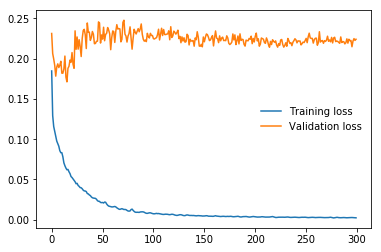

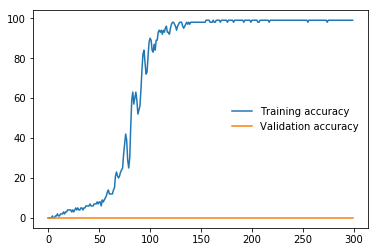

Elapsed time for 300epoci-FC-mix-80-10-10-v1(7)-v2(32).pth : 00:24:02.08
Test set ->  test loss:  0.05461573631637805 accuracy:  79 % [396/498]
Test set ->  test loss:  0.10108456361162697 accuracy:  25 % [129/498]


In [35]:
import winsound
import os

voice1 = 'recordings/voice1/arctic_a0007.wav'
voice2 = 'recordings/voice2/arctic_a0032.wav'
    

# torch.cuda.empty_cache()
# model_name = runAdam(300, train_set, valid_set, test_set_with_noise, "FC-mix-intreg-v1(7)-v2(32)")

# # test first what it learned from train
# mix = get_mix_from_voices(voice1, voice2, mix_5_sec=True)
# network = torch.load(model_name)
# test_mask = eval(network=network, test_set=test_set)
# split_audios_epoch("FC-mix-intreg-v1(7)-v2(32)-test", test_mask, mix, samples_per_frame=samples_per_frame_10ms)

# # test with noise
# mix = get_mix_from_voices_with_noise(voice1, voice2, 'recordings/noises/piano5sec.wav', mix_5_sec = True)
# network = torch.load(model_name)
# test_mask = eval(network=network, test_set=test_set_with_noise)
# split_audios_epoch("FC-mix-intreg-v1(7)-v2(32)-test-noise", test_mask, mix, samples_per_frame=samples_per_frame_10ms)
#-----------------------------------------------------------------------------------

# torch.cuda.empty_cache()
# model_name = runAdamConv(200, train_set, valid_set, test_set_with_noise, "CONV-mix-intreg-v1(7)-v2(32)")

# # test first what it learned from train
# mix = get_mix_from_voices(voice1, voice2)
# network = torch.load(model_name)
# test_mask = eval(network=network, test_set=test_set)
# split_audios_epoch("CONV-mix-intreg-v1(7)-v2(32)-test", test_mask, mix)

# # test with noise
# mix = get_mix_from_voices_with_noise(voice1, voice2, 'recordings/noises/piano5sec.wav')
# network = torch.load(model_name)
# test_mask = eval(network=network, test_set=test_set_with_noise)
# split_audios_epoch("CONV-mix-intreg-v1(7)-v2(32)-test-noise", test_mask, mix)

#-----------------------------------------------------------------------------------


torch.cuda.empty_cache()
model_name = runAdam(300, train_set_80, valid_set_10, test_set_10, "FC-mix-80-10-10-v1(7)-v2(32)")

# test first what it learned from train
mix = get_mix_from_voices(voice1, voice2, mix_5_sec=True)
network = torch.load(model_name)
test_mask = eval(network=network, test_set=test_set)
split_audios_epoch("FC-mix-80-10-10-v1(7)-v2(32)-test", test_mask, mix, samples_per_frame_10ms)

# test with noise
mix = get_mix_from_voices_with_noise(voice1, voice2, 'recordings/noises/piano5sec.wav', mix_5_sec=True)
network = torch.load(model_name)
test_mask = eval(network=network, test_set=test_set_with_noise)
split_audios_epoch("FC-mix-80-10-10-v1(7)-v2(32)-test-noise", test_mask, mix, samples_per_frame_10ms)

# #-----------------------------------------------------------------------------------

# torch.cuda.empty_cache()
# model_name = runAdamConv(200, train_set_80, valid_set_10, test_set_10, "CONV-mix-80-10-10-v1(7)-v2(32)")

# # test first what it learned from train
# mix = get_mix_from_voices(voice1, voice2)
# network = torch.load(model_name)
# test_mask = eval(network=network, test_set=test_set)
# split_audios_epoch("CONV-mix-80-10-10-v1(7)-v2(32)-test", test_mask, mix)

# # test with noise
# mix = get_mix_from_voices_with_noise(voice1, voice2, 'recordings/noises/piano5sec.wav')
# network = torch.load(model_name)
# test_mask = eval(network=network, test_set=test_set_with_noise)
# split_audios_epoch("CONV-mix-80-10-10-v1(7)-v2(32)-test-noise", test_mask, mix)

# #-----------------------------------------------------------------------------------

duration = 1000  # milliseconds
freq = 440  # Hz
winsound.Beep(freq, duration)
